# Computing Trends in ECCO Output

#### Overview
In this notebook, we will look at a simple way tp analyze ocean model output - computing a trend. As in the previous notebook, we will use output from the ECCO Ocean State Estimate (Version 4).

#### Import Modules
First, import the modules required to access data from netCDF files and create plots:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm

After the modules are loaded in, establish a path to your data directory for this clas:

## Data for this notebook
In this notebook, we will use sea ice data from the Versions 4 state estimate. To download the data, you can use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook available on the Github for this book. Use the following settings to download the pertinent data:

```
version = 'Version4'
release = 'Release4'
subset = 'interp_monthly'
var_name = 'SIarea'
start_year = 1992
end_year = 2017
```

Once the data is downloaded, identify the location of your data folder here:

In [2]:
# Define a path to a data folder
data_folder = '../../ocean_modeling_book_data/data'

## From visualizing to analyzing
In the previous notebook, we've focused on visualizing model output - first in space and then in time with timeseries and Hövmoller diagrams. But in all of this visualization, we have not done any real computation. Here, we'll start to look at ways to *quantify* change, starting with investigating trends.

### Example: Change in Northern Hemisphere Sea Ice
In this example, we'll investigate changes in sea ice in the Arctic ocean. Let's take a look at one of the data fields using the plotting routines from the previous notebook:

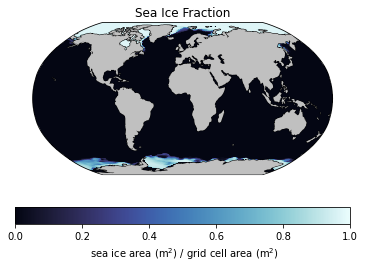

In [3]:
# make a path to a sea ice file
seaice_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SIarea','SIarea_2015_01.nc')

# read in the sea ice data at along with the
# latitude and longitude information 
ds = xr.open_dataset(seaice_file)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])
SIarea = np.array(ds['SIarea'][:])
ds.close()

# subset sea ice to the first time step
SIarea = SIarea[0, :, :]

# create a figure object
fig = plt.figure()
ax = plt.axes(projection=ccrs.Robinson())

# plot the seaice
plt.pcolormesh(longitude, latitude, SIarea, vmin=0, vmax=1, cmap=cm.ice,
               transform=ccrs.PlateCarree())
plt.colorbar(orientation = 'horizontal', label=' sea ice area (m$^2$) / grid cell area (m$^2$)')

# add coastlines
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
plt.gca().coastlines()

# format the axes
plt.title('Sea Ice Fraction')
plt.show()

In looking at the units of sea ice above, it's clear that we need to multiply each grid cell by it's area to retrieve the total area of the sea ice since each cell gives the fraction covered by sea ice. Conceptually, it's easy to do - just multiply the fraction by the cell area. But what's the cell area? This is a little trickier since our data is given in longitude-latitude coordinates. Further, the area of cells at the equator are larger than those at the poles. We can check this out in a simple plot of the globe with grid lines:

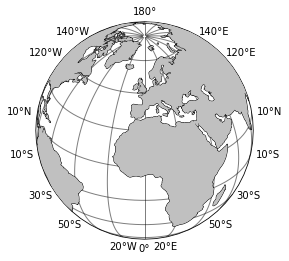

In [4]:
import matplotlib.ticker as mticker

# make a figure object with projection
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude = 30))

# add coastlines
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
plt.gca().coastlines()

# add grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='-')
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,20))
# format the axes
plt.show()

### Computing areas
If we assume the Earth is a perfect sphere with radius $R=$ 6,371 km, it's fairly straight-forward to compute the area of each cell if we think of each cell as taking up a given proportion of the sphere. On one hand, the area of a vertical latitude band between $\phi_1$ and $\phi_0$ has area

$$
A_{\text{Longitude Band}} = A_{Earth} \left(\frac{\phi_1 - \phi_0}{2\pi}\right)  = 2 R^2 (\phi_1 - \phi_0)
$$

Further, a little trigonometry shows the the area of a portion of the sphere between the equator and a given latitude ($\theta$) is scaled by the *sin* of the latitude. Thus, in a given latitude band between $\theta_1$ and $\theta_0$, the fractional area is  

$$
A_{\text{Latitude Band}} = A_{Earth}\left(\frac{\sin (\theta_1) - \sin (\theta_0)}{2}\right)
$$

Putting these pieces together, we can compute the surface area of a given area of a sphere as 

$$
A_{patch} = R^2 (\phi_1 - \phi_0) (\sin (\theta_1) - \sin (\theta_0)) 
$$


In [5]:
# define the lon and lat bounds
lon_step = 0.5
lat_step = 0.5
lon_bounds = np.arange(-180, 180.01, lon_step)
lat_bounds = np.arange(-90, 90.01, lon_step)

# convert to radians
lon_bounds_rad = np.deg2rad(lon_bounds)
lat_bounds_rad = np.deg2rad(lat_bounds)

# make an array to store the area in each cell
R = 6371000
Area = np.zeros((360, 720))
for i in range(len(lon_bounds)-1):
    for j in range(len(lat_bounds)-1):
        Area[j,i] = R**2 * (lon_bounds_rad[i+1] - lon_bounds_rad[i]) * \
        (np.sin(lat_bounds_rad[j+1]) - np.sin(lat_bounds_rad[j])) 

As with any formula, it's a good idea to sanity check your results. Here, we know the each of a sphere should be $4\pi R^2$, so let's check the numbers line up:

In [6]:
# sanity check
print(np.sum(Area))
print(np.pi * 4 * R**2)

510064471909788.3
510064471909788.25


Looks good! We can even plot the area to be sure:

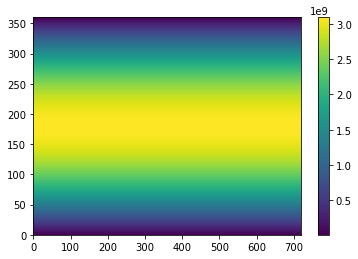

In [7]:
# make a plot of the Area with a colorbar
C = plt.pcolormesh(Area)
plt.colorbar(C)
plt.show()

As expected, the area is greater at the equator than the poles. Ok, now onto the trends:

### Sea Ice Area in the Northern Hemisphere
Equipped with our area function, we are now ready to compute the total sea ice area in the northern hemisphere through time. Let's make a list of files first, and then loop through them to compute the area:

In [8]:
# make a list to contain the file names
file_list = []

# loop through the 12 months
for year in range(1992,2018):
    for month in range(1,13):
        file_list.append('SIarea_'+str(year)+'_'+'{:02d}'.format(month)+'.nc')

# print out the file names (if desired)
# print(file_list)

Now, loop through each file in the list, storing the total area of the sea ice in an array for plotting:

In [9]:
# make a list to store the temperature values
si_area = np.zeros((len(file_list),))

# loop through each file
for i in range(len(file_list)):
    
    # identify path to the data file
    month_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SIarea',file_list[i])
    
    # read in the data 
    ds = xr.open_dataset(month_file)
    SIarea = np.array(ds['SIarea'][:])
    ds.close()

    # subset to first timestep
    SIarea = SIarea[0,:,:]

    # mask points in the southern ocean
    SIarea[:180, :] = 0

    # compute the total sea ice area
    total_area = np.sum(SIarea*Area)

    # add the computed area to the list
    # the list of temperatures
    si_area[i] = total_area

Now that we've got our sea ice area timeseries, let's make a plot:

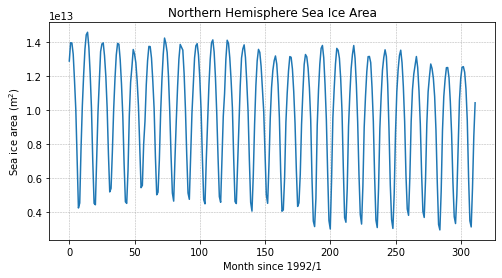

In [10]:
fig = plt.figure(figsize=(8,4))
plt.plot(si_area)
plt.title('Northern Hemisphere Sea Ice Area')
plt.ylabel('Sea ice area (m$^2$)')
plt.xlabel('Month since 1992/1')
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

### Computing Trends
How much has sea ice declined in the time period shown above? Let's compute a trend line to determine how much ice is lost during this time period. To keep things simple, we'll just compute the trend for all months of available data although this trend is often computed for September values only.

First things first, we need to define a time array.

In [11]:
# define a time array for months
months = np.arange(len(file_list))

# convert to "decimal years" for simplicity
years = 1992 + months/12

With the time array in hand, we can now fit a line to the data. To fit a simple trend line, we can use the `polyfit` function from `numpy` with a degree of 1:

In [12]:
# compute the line coefficients
line_coefficients = np.polyfit(years, si_area, deg=1)

# print the coefficients
print(line_coefficients)

# sanity check: one is the slope and one is intercept - which is which?

[-7.11897578e+10  1.52390956e+14]


Let's plot the trend line on the data to ensure it looks as expected:

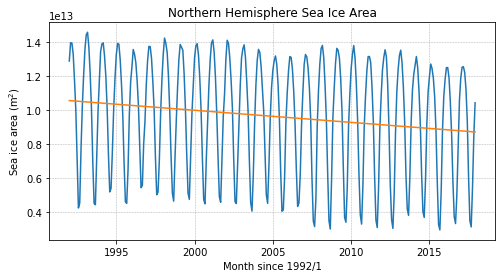

In [13]:
fig = plt.figure(figsize=(8,4))

# plot the data
plt.plot(years, si_area)

# plot the trend line
plt.plot(years, line_coefficients[0]*years + line_coefficients[1])

plt.title('Northern Hemisphere Sea Ice Area')
plt.ylabel('Sea ice area (m$^2$)')
plt.xlabel('Month since 1992/1')
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

### Interpreting Trends
The slope of the trend line estimates how much the variable is changing through time. Consider the following questions:
1. Is northern hemisphere sea ice being lost or gained?
2. What are the units of the slope of the trend line?
3. What is the equivalent slope in units of square miles? ($1$ mile$^2$ = $2.59 \times 10^6$ m$^2$)

Solutions:

1. The slope of the line, given by the first coefficient, is negative, indicating that sea ice is being lost.
2. The units of the trend line are m$^2$ per year since the sea ice area is in m$^2$ and the time is in "decimal years".
3. To compute the trend in square miles, we can do a simple conversion using the information above:

In [14]:
# compute the trend in square miles
sq_miles = line_coefficients[0]*(1/2.59e6)

# print out the result
print('Square miles of Arctic sea ice lost per year:',sq_miles)

Square miles of Arctic sea ice lost per year: -27486.392961071546


### &#x1F914; Try it yourself
How do the trends in the Southern Hemisphere compare to those in the Northern Hemisphere during this time period? The answers may suprise you.